In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

from sklearn.impute import SimpleImputer
#from sklearn.pipeline import Pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# TensorFlow ≥2.0 is required
import tensorflow_addons as tfa
import tensorflow as tf
assert tf.__version__ >= '2.0'

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from numpy.random import randn, randint
from keras.datasets import fashion_mnist
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation,AveragePooling2D,GlobalAveragePooling2D
from keras import initializers
from keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import dask
import datetime
import math
dask.config.set({'array.slicing.split_large_chunks': False})

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Custom utils
from utils.utils_data import *
from utils.utils_ml import *
from utils.utils_plot import *
from utils.utils_unet import *
from utils.utils_resnet import *

In [5]:
# Paths
DATADIR = '/storage/workspaces/giub_hydro/hydro/data/'
#DATADIR = os.path.join(os.getcwd(), '..', 'data')

# Some constants
DATE_START = '1979-01-01'
DATE_END = '2020-12-31'
YY_TRAIN = [1979, 2015]
YY_VAL = '2014'
YY_TEST = [2016, 2020]
sel_levels = [500, 850, 1000]
G = 9.80665 

In [6]:
# Read data
# Precipitation ERA5
pr = get_era5_data(DATADIR + '/ERA5/precipitation/day_grid1/*nc', DATE_START, DATE_END)
lon_pr=pr.lon
lat_pr=pr.lat
pr_Datarray = xr.DataArray(pr.tp) # to make the format as pr95
# Define precipitation extremes using the 95th
th95 = 0.95
pr95 = precip_exceedance_xarray(pr, th95)

Extracting data for the period 1979-01-01 - 2020-12-31


In [7]:
# Read covariates: RH, T2m, geopotential, wind (1x1deg)
z = get_era5_data(DATADIR + '/ERA5/geopotential/grid1/*.nc', DATE_START, DATE_END)
z = z.sel(level=sel_levels)
# Get Z in geopotential height (m)
z.z.values = z.z.values/G
# select the same coordinates values than precipitation
z_new = z.sel(lon=slice(min(lon_pr), max(lon_pr)))

Extracting data for the period 1979-01-01 - 2020-12-31


In [8]:
# temperature
t2m = get_era5_data(DATADIR + '/ERA5/temperature/grid1/Grid1_Daymean_era5_T2M_EU_19790101-20211231.nc', DATE_START, DATE_END)
t2m['time'] = pd.DatetimeIndex(t2m.time.dt.date)
# select the same coordinates values than precipitation
t2m_new = t2m.sel(lon=slice(min(lon_pr), max(lon_pr)))
t2m_1lev = t2m_new.expand_dims('level', axis=1)

Extracting data for the period 1979-01-01 - 2020-12-31


In [9]:
# relative humidity
rh = get_era5_data(DATADIR + '/ERA5/relative_humidity/day_grid1/*.nc', DATE_START, DATE_END)
rh['time'] = pd.DatetimeIndex(rh.time.dt.date) # need to have the same time-format
rh = rh.sel(level=sel_levels)
rh_new = rh.sel(lon=slice(min(lon_pr), max(lon_pr)))

Extracting data for the period 1979-01-01 - 2020-12-31


In [10]:
# Wind components 850hpa
u850 = get_era5_data(DATADIR + '/ERA5/U_wind/day_grid1/*.nc', DATE_START, DATE_END)
u850['time'] = pd.DatetimeIndex(u850.time.dt.date)
u850_new = u850.sel(lon=slice(min(lon_pr), max(lon_pr)))
v850 = get_era5_data(DATADIR + '/ERA5/V_wind/day_grid1/*.nc', DATE_START, DATE_END)
v850['time'] = pd.DatetimeIndex(v850.time.dt.date)
v850_new = v850.sel(lon=slice(min(lon_pr), max(lon_pr)))

Extracting data for the period 1979-01-01 - 2020-12-31
Extracting data for the period 1979-01-01 - 2020-12-31


In [11]:
# checking dimensions
print('dimension of z',z_new.dims)
print('dimension of t2m:',t2m_new.dims)
print('dimension of rh:',rh_new.dims)
print('dimension of u:',u850_new.dims)
print('dimension of pr:',pr.dims)

dimension of z Frozen({'time': 15341, 'lon': 71, 'lat': 51, 'level': 3})
dimension of t2m: Frozen({'time': 15341, 'lon': 71, 'lat': 51})
dimension of rh: Frozen({'time': 15341, 'lon': 71, 'lat': 51, 'level': 3})
dimension of u: Frozen({'time': 15341, 'lon': 71, 'lat': 51})
dimension of pr: Frozen({'time': 15341, 'lon': 71, 'lat': 51})


In [20]:
# Then we need a dictionary for all the variables and levels we want to extract from the dataset
#dic = OrderedDict({'z': 3, 'T2MMEAN':None, 'r':3})
bs = 32
dic = {'z': sel_levels,
       'T2MMEAN': None,
       'r': sel_levels,
       'u': None,
       'v': None}

In [23]:
# Data preparation
# For the data generator all variables have to be merged into a single dataset.
datasets = [z_new, t2m_new, rh_new, u850_new, v850_new]
ds = xr.merge(datasets)

In [109]:
ds

<xarray.Dataset>
Dimensions:  (lat: 51, time: 15341, lon: 71, level: 3)
Coordinates:
  * lat      (lat) float64 30.0 31.0 32.0 33.0 34.0 ... 76.0 77.0 78.0 79.0 80.0
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2020-12-31
  * lon      (lon) float64 -40.0 -39.0 -38.0 -37.0 -36.0 ... 27.0 28.0 29.0 30.0
  * level    (level) float64 500.0 850.0 1e+03
Data variables:
    z        (time, level, lat, lon) float32 5.698e+03 5.714e+03 ... 114.0 114.9
    T2MMEAN  (time, lat, lon) float32 dask.array<chunksize=(15341, 51, 71), meta=np.ndarray>
    r        (time, level, lat, lon) float32 dask.array<chunksize=(365, 3, 51, 71), meta=np.ndarray>
    u        (time, lat, lon) float32 dask.array<chunksize=(365, 51, 71), meta=np.ndarray>
    v        (time, lat, lon) float32 dask.array<chunksize=(365, 51, 71), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Wed Jan 12 11:54:40 2022: cdo -f nc -remapbil,/storage/home...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [24]:
# Split into training and test, then I will use DataGenerator class to get the validation
ds_train = ds.sel(time=slice('{}-01-01'.format(YY_TRAIN[0]),
                             '{}-12-31'.format(YY_TRAIN[1])))
ds_test = ds.sel(time=slice('{}-01-01'.format(YY_TEST[0]),
                            '{}-12-31'.format(YY_TEST[1])))

In [25]:
# Create a training and validation data generator. Use the train mean and std for validation as well.
lead_time = 5 # just in case of need
dg_train = DataGenerator_extended(ds_train.sel(time=slice('1979', '2014')), dic, lead_time, batch_size=bs, load=True)

Loading data into RAM


In [26]:
# Create a validation. Use the train mean and std for validation as well. And suffle
dg_val = DataGenerator_extended(ds_train.sel(time=slice('2015', '2015')), dic,lead_time, batch_size=bs,  mean=dg_train.mean, std=dg_train.std, load=True)

Loading data into RAM


In [27]:
# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = DataGenerator_extended(ds_test, dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM


In [28]:
# Prepare the data
X_train = xr.DataArray(dg_train.data)
X_val = xr.DataArray(dg_val.data)
X_test = xr.DataArray(dg_test.data)

In [29]:
X_train_input = np.array(X_train)
X_val_input = np.array(X_val)
X_test_input = np.array(X_test)

In [33]:
Y_train, Y_val, Y_test = get_Y_sets(pr95, YY_TRAIN, YY_VAL, YY_TEST)

In [34]:
input_s = X_train[:,0:48,0:64,:].shape[1:]
input_s

(48, 64, 9)

## CNN + LSTM

In [102]:
cnn_model = Sequential()
cnn_model.add(TimeDistributed(Conv2D(20, (3, 3), padding='same', activation='relu'), input_shape=(48, 64, 9,1))) # for Timedistributed it has to be one more dimension
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.2))
cnn_model.add(TimeDistributed(AveragePooling2D(2)))
cnn_model.add(TimeDistributed(GlobalAveragePooling2D()))
cnn_model.add(LSTM(25, activation='relu'))
cnn_model.add(Dense(1*48*64))
cnn_model.add(Activation('sigmoid'))
cnn_model.add(Reshape((48, 64)))

In [103]:
cnn_model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_19 (TimeDi  (None, 48, 64, 9, 20)    200       
 stributed)                                                      
                                                                 
 batch_normalization_16 (Bat  (None, 48, 64, 9, 20)    80        
 chNormalization)                                                
                                                                 
 dropout_16 (Dropout)        (None, 48, 64, 9, 20)     0         
                                                                 
 time_distributed_20 (TimeDi  (None, 48, 32, 4, 20)    0         
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 48, 20)           0         
 stributed)                                          

In [104]:
cnn_model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

In [105]:
hist = cnn_model.fit(X_train_input[:,0:48,0:64,:],
                     Y_train[:,0:48,0:64],
                     epochs=10,
                     validation_data=(X_val_input[:,0:48,0:64,:], Y_val[:,0:48,0:64]),
                         shuffle=True)
                   

Epoch 1/10
411/411 [==============================] - 37s 83ms/step - loss: 0.2293 - accuracy: 0.0336 - val_loss: 0.2087 - val_accuracy: 0.0390
Epoch 2/10
411/411 [==============================] - 34s 82ms/step - loss: 0.1887 - accuracy: 0.0571 - val_loss: 0.2034 - val_accuracy: 0.0729
Epoch 3/10
411/411 [==============================] - 34s 82ms/step - loss: 0.1840 - accuracy: 0.0752 - val_loss: 0.1970 - val_accuracy: 0.0917
Epoch 4/10
411/411 [==============================] - 34s 82ms/step - loss: 0.1809 - accuracy: 0.0802 - val_loss: 0.1952 - val_accuracy: 0.0957
Epoch 5/10
411/411 [==============================] - 34s 82ms/step - loss: 0.1786 - accuracy: 0.0865 - val_loss: 0.1914 - val_accuracy: 0.0904
Epoch 6/10
411/411 [==============================] - 34s 82ms/step - loss: 0.1766 - accuracy: 0.0877 - val_loss: 0.1889 - val_accuracy: 0.0705
Epoch 7/10
411/411 [==============================] - 33s 81ms/step - loss: 0.1749 - accuracy: 0.0886 - val_loss: 0.1880 - val_accuracy:

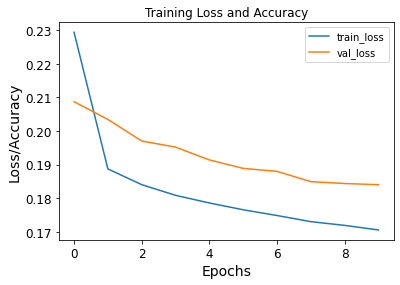

In [106]:
plot_hist(hist)

In [107]:
pred1 = cnn_model.predict(X_test_input[:,0:48,0:64,:])

In [108]:
pred1

array([[[0.01689149, 0.01884289, 0.01711764, ..., 0.01381752,
         0.01057678, 0.00787902],
        [0.0141195 , 0.01375512, 0.01204763, ..., 0.00366214,
         0.00500357, 0.00828807],
        [0.01542398, 0.01530268, 0.01177308, ..., 0.00813369,
         0.00541869, 0.00420328],
        ...,
        [0.02875303, 0.02111751, 0.02077489, ..., 0.09669425,
         0.09889791, 0.08138775],
        [0.02861203, 0.02250432, 0.02194273, ..., 0.07118953,
         0.06783   , 0.06094268],
        [0.02034982, 0.02056386, 0.02555567, ..., 0.04800094,
         0.03256714, 0.0490697 ]],

       [[0.02178693, 0.02718466, 0.0274539 , ..., 0.01405579,
         0.01052723, 0.00811886],
        [0.02338697, 0.02422477, 0.024894  , ..., 0.00923308,
         0.01009197, 0.01357883],
        [0.03113553, 0.0291655 , 0.02495333, ..., 0.01315372,
         0.00958534, 0.0079758 ],
        ...,
        [0.04140832, 0.03045387, 0.02716237, ..., 0.14168482,
         0.14402995, 0.11670453],
        [0.0

In [96]:
model = Sequential()
model.add(Input(shape=input_s))
model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
#model.add(Reshape((24*32, 16)))  # I need to reshape, as the LSTM expect a tensor 2D
#model.add(LSTM(units=16,return_sequences=True))
#model.add(Dense(1))
#model.add(Flatten())
#model.add(Reshape((24, 32, 1)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(1, (1,3), activation='sigmoid', padding='same'))

In [97]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 48, 64, 16)        1312      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 24, 32, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_15 (Bat  (None, 24, 32, 16)       64        
 chNormalization)                                                
                                                                 
 dropout_15 (Dropout)        (None, 24, 32, 16)        0         
                                                                 
 conv2d_39 (Conv2D)          (None, 24, 32, 16)        2320      
                                                                 
 up_sampling2d_6 (UpSampling  (None, 48, 64, 16)     

In [98]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

In [99]:
hist = model.fit(X_train_input[:,0:48,0:64,:],
                     Y_train[:,0:48,0:64],
                     epochs=10,
                     validation_data=(X_val_input[:,0:48,0:64,:], Y_val[:,0:48,0:64]),
                         shuffle=True)

Epoch 1/10
411/411 [==============================] - 4s 7ms/step - loss: 0.2084 - accuracy: 0.9492 - val_loss: 0.2121 - val_accuracy: 0.9444
Epoch 2/10
411/411 [==============================] - 3s 7ms/step - loss: 0.1964 - accuracy: 0.9505 - val_loss: 0.2114 - val_accuracy: 0.9444
Epoch 3/10
411/411 [==============================] - 3s 8ms/step - loss: 0.1949 - accuracy: 0.9505 - val_loss: 0.2106 - val_accuracy: 0.9444
Epoch 4/10
411/411 [==============================] - 3s 7ms/step - loss: 0.1942 - accuracy: 0.9505 - val_loss: 0.2096 - val_accuracy: 0.9444
Epoch 5/10
411/411 [==============================] - 3s 6ms/step - loss: 0.1936 - accuracy: 0.9505 - val_loss: 0.2092 - val_accuracy: 0.9444
Epoch 6/10
411/411 [==============================] - 3s 7ms/step - loss: 0.1931 - accuracy: 0.9505 - val_loss: 0.2088 - val_accuracy: 0.9444
Epoch 7/10
411/411 [==============================] - 3s 8ms/step - loss: 0.1927 - accuracy: 0.9505 - val_loss: 0.2085 - val_accuracy: 0.9444
Epoch 

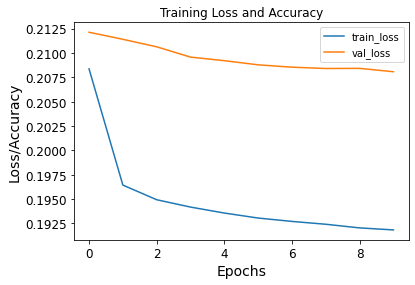

In [100]:
plot_hist(hist)